# Automatic classification of eclipsing binary stars using deep learning methods

In [1]:
import numpy as np
import pandas as pd
import json
import pickle
np.random.seed(1234)


from sklearn.model_selection import train_test_split


from keras.utils import np_utils
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Bidirectional, Flatten, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt


import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import scikitplot as skplt

In [2]:
# V pripade ak boli chyby s importami, tak je potrebne to spustit (robi sa so zdielanymi prostrediami)

# %pip install keras
# %pip install elisa
# %pip install imblearn
# %pip install --upgrade tensorflow
# %pip install --upgrade tensorflow-gpu
# %pip install scikit-plot

     |████████████████████████████████| 1.4 MB 7.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 406 kB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 11.2 MB 37.9 MB/s eta 0:00:01
     |████████████████████████████████| 41 kB 110 kB/s  eta 0:00:01
     |████████████████████████████████| 11.6 MB 67.6 MB/s eta 0:00:01
     |████████████████████████████████| 10.4 MB 68.4 MB/s eta 0:00:01
     |████████████████████████████████| 775 kB 59.9 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 72.6 MB/s eta 0:00:01
     |████████████████████████████████| 25.7 MB 32.6 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotli

## Data load

- load observed light curve 


In [2]:
data = pd.read_csv("observed_new3.csv",usecols = ['Type','filter', 'curve', 'name'] )
data.head(20)

,Type,name,filter,curve
0,overcontact,AH Aur,V,"[0.6897, 0.6901, 0.6904, 0.691, 0.6916, 0.6925..."
1,overcontact,AH Aur,B,"[0.656, 0.6549, 0.6537, 0.6525, 0.6516, 0.6513..."
2,overcontact,AKHer,V,"[0.6688, 0.6646, 0.6608, 0.6572, 0.6539, 0.651..."
3,overcontact,AKHer,B,"[0.6127, 0.6129, 0.6131, 0.6136, 0.6142, 0.615..."
4,overcontact,AKHer,I,"[0.6932, 0.6884, 0.6841, 0.6804, 0.6773, 0.674..."
5,overcontact,AKHer,R,"[0.6524, 0.6518, 0.652, 0.6532, 0.6554, 0.6582..."
6,overcontact,ASCrB,V,"[0.6961, 0.6958, 0.6957, 0.6959, 0.6963, 0.697..."
7,overcontact,ASCrB,B,"[0.6762, 0.678, 0.6797, 0.6807, 0.6811, 0.6811..."
8,overcontact,ASCrB,I,"[0.7145, 0.7137, 0.713, 0.7128, 0.7129, 0.7134..."
9,overcontact,ASCrB,R,"[0.6996, 0.6992, 0.6991, 0.6996, 0.7005, 0.701..."


In [3]:
data = data.replace(to_replace='overcontact', value=1)
data = data.replace(to_replace='detached', value=0)
data

,Type,name,filter,curve
0,1,AH Aur,V,"[0.6897, 0.6901, 0.6904, 0.691, 0.6916, 0.6925..."
1,1,AH Aur,B,"[0.656, 0.6549, 0.6537, 0.6525, 0.6516, 0.6513..."
2,1,AKHer,V,"[0.6688, 0.6646, 0.6608, 0.6572, 0.6539, 0.651..."
3,1,AKHer,B,"[0.6127, 0.6129, 0.6131, 0.6136, 0.6142, 0.615..."
4,1,AKHer,I,"[0.6932, 0.6884, 0.6841, 0.6804, 0.6773, 0.674..."
...,...,...,...,...
81,0,XZAql,I,"[0.3353, 0.3306, 0.3297, 0.3326, 0.339, 0.3491..."
82,0,Y Cam,V,"[0.2483, 0.2451, 0.2465, 0.2537, 0.267, 0.2854..."
83,0,WYHya,V,"[0.4113, 0.4087, 0.4076, 0.4083, 0.4108, 0.415..."
84,0,WYHya,B,"[0.3927, 0.3923, 0.3926, 0.3936, 0.3954, 0.398..."


### Check data 

In [19]:
# data["id"] = data["id"].astype(int)
# data["overcontact"] = data["overcontact"].astype(int)

In [4]:
data.dtypes

Type       int64
name      object
filter    object
curve     object
dtype: object

In [5]:
data['Type'].value_counts()

1    46
0    40
Name: Type, dtype: int64

## Data preparation
- bessel_to_array 

In [6]:
def bessel_to_array(column_name, df):
    """Model expects array input. 
    This function transforms all curves in 1 column (400 comma seperated numbers) to array"""
    newData_bessell = []
    for row in df[column_name]:
        if pd.isna(row):
            print(row,"df")
            continue
        newRow = []
        letter_list = row.split(",")
        for number in letter_list:
            number = number.replace(']', '')
            number = number.replace('[', '')
            newRow.append(float(number))
        newData_bessell.append(newRow) 
    newData_bessell = np.array(newData_bessell)
    print(newData_bessell)
    return newData_bessell

In [7]:
data_curve = []
for column in ['curve']:
    data_curve.append(bessel_to_array(column, data))
    print(column + " " + "prossessed")

[[0.6897 0.6901 0.6904 ... 0.6875 0.6885 0.6891]
 [0.656  0.6549 0.6537 ... 0.6597 0.6584 0.6573]
 [0.6688 0.6646 0.6608 ... 0.6839 0.6784 0.6734]
 ...
 [0.4113 0.4087 0.4076 ... 0.4246 0.42   0.4157]
 [0.3927 0.3923 0.3926 ... 0.4006 0.3969 0.3944]
 [0.4303 0.4292 0.4284 ... 0.4347 0.433  0.4316]]
curve prossessed


In [8]:
print(np.array(data_curve).shape)


(1, 86, 400)


In [9]:
# target is overcontact
target = np.array(data['Type'])
print(target)

# just to be sure that both types are in dataset
exists = 0 in target
print(exists)
exists = 1 in target
print(exists)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
True
True


> Control the shape and check if the dataset is imbalanced (ale nacital som si z oboch 10 000 cize viem ze by mal byt vyvazeny)

In [10]:
print(target.shape)
print(Counter(target))

(86,)
Counter({1: 46, 0: 40})


    - fit and apply the transform

In [11]:
def print_shape_counter(column, target):
    print(column.shape)
    print(target.shape)
    print(Counter(target))

In [12]:
for i in range(1):
    print_shape_counter(data_curve[i], data['Type'])
    print("")

(86, 400)
(86,)
Counter({1: 46, 0: 40})



# Model Observed evaluation

In [13]:
def evaluate_all(model_path, input_data, y_test):
    classifier = load_model(model_path)
    # y_pred returns probability of detached and overcontact 
    # for example [1.4059671e-04, 9.9985933e-01], 
    # means detached with prob. 0.0001405  and overcontact with prob 0.998
    y_pred = classifier.predict(input_data)
    # print(y_pred)
    
    # for example [1.4059671e-04, 9.9985933e-01] -> [0, 1], it is marked as detached 
    y_pred2 = np.where(y_pred > 0.4, 1, 0)
    
    # test data [0,1,...] is converted to categorical [[0,1],[1,0]]
    target_test = np.array(y_test)
    target_test = np_utils.to_categorical(target_test, 2)
    
    # confusion matrix -old 
    # cm = confusion_matrix(target_test.argmax(axis=1), y_pred2.argmax(axis=1))
    # print("Confusion matrix: \n" + str(cm))
    
    # confusion matrix - nice print 
    matrix=skplt.metrics.plot_confusion_matrix(target_test.argmax(axis=1), y_pred2.argmax(axis=1))
    matrix.xaxis.set_ticklabels(['detached', 'overcontact'])
    matrix.yaxis.set_ticklabels(['detached', 'overcontact'])
    matrix
    
    target_names= ['detached', 'overcontact']
    print("Classification report: \n" + classification_report(target_test.argmax(axis=1), y_pred2.argmax(axis=1),target_names=target_names))
    # from categorical [0, 1] -> 1
    y_true = target_test.argmax(axis=1)
    
    skplt.metrics.plot_roc(y_true, y_pred)
    plt.savefig('roc_auc.png')
    plt.show()
    
    input_data = np.array(input_data)
    y_test2=data[['name', 'Type']]

    

    for j in range(len(y_pred2)): 
        if (y_pred2[j].argmax(axis=0) == 1) and (target_test[j].argmax(axis=0) == 0):
            if input_data.ndim == 4:
                plt.plot(input_data[0][j],label = str(y_test2.iloc[[j]].name) + ", " +str(y_test.iloc[[j]].values[0]))

                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "detached 0", ha="center", va="bottom", color="green")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "overcontact 1", ha="center", va="bottom",  color="red")

            else:
                plt.plot(input_data[j],label = str(y_test2.iloc[[j]].name) + ", " +str(y_test.iloc[[j]].values[0]))

                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "detached 0", ha="center", va="bottom" ,color="green")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62,0.9, "overcontact 1", ha="center", va="bottom",  color="red")


    
    plt.legend(loc='upper right')       
    plt.savefig('image.png')
    plt.show()     


    for j in range(len(y_pred2)): 
        if (y_pred2[j].argmax(axis=0) == 0) and (target_test[j].argmax(axis=0) == 1):
            if input_data.ndim == 4:
                plt.plot(input_data[0][j],label = str(data.iloc[[j]].name) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "detached 0", ha="center", va="bottom", color="red")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "overcontact 1", ha="center", va="bottom",  color="green")

            else:
                plt.plot(input_data[j],label = str(data.iloc[[j]].name) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "detached 0", ha="center", va="bottom", color="red")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "overcontact 1", ha="center", va="bottom",  color="green")

    
    plt.legend(loc='upper right')       
    plt.savefig('image2.png')
    plt.show()
    
   
    print(y_test2)

(86,)
(86, 400)
Classification report: 
              precision    recall  f1-score   support

    detached       0.93      1.00      0.96        40
 overcontact       1.00      0.93      0.97        46

    accuracy                           0.97        86
   macro avg       0.97      0.97      0.97        86
weighted avg       0.97      0.97      0.97        86



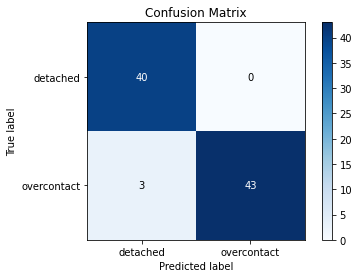

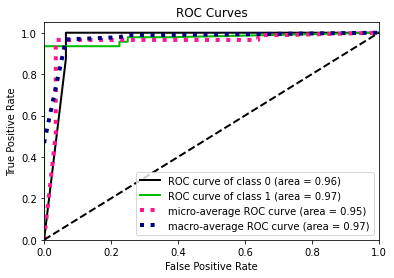

No handles with labels found to put in legend.


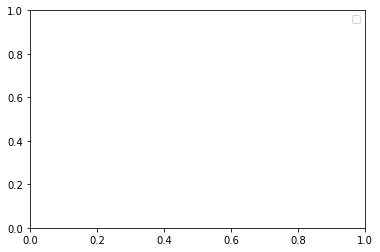

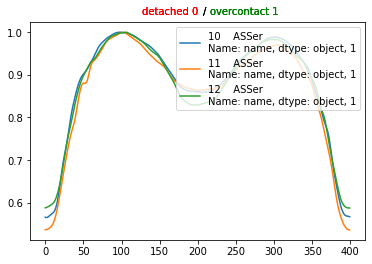

      name  Type
0   AH Aur     1
1   AH Aur     1
2    AKHer     1
3    AKHer     1
4    AKHer     1
..     ...   ...
81   XZAql     0
82   Y Cam     0
83   WYHya     0
84   WYHya     0
85   WYHya     0

[86 rows x 2 columns]


In [14]:
processed_test_data= data_curve[0]

y_test_mixed = data['Type']

print(y_test_mixed.shape)
print(processed_test_data.shape)

evaluate_all('model_experiment_3_50000.hdf5', processed_test_data, y_test_mixed)